# Proyecto Machine Learning - Clasificacion de imagenes
# -- Clasificacion si una persona porta o no mascarilla --
## Grupo: 6CV3
## Integrantes:
* Pérez Mongragón Eduardo
* Rosiles Hidalgo Emanuel

# Arquitectura Personalizada

In [63]:
import os
import random
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocesamiento - Redimensionamiento de imagenes de entrenamiento

In [64]:
def redimencionar_imagenes(dataset_path, target_size, nombre_clase, nombre_carpeta):
    resized_path = os.path.join(dataset_path, nombre_carpeta)
    os.makedirs(resized_path, exist_ok=True)

    original_path = os.path.join(dataset_path, nombre_clase)

    file_list = os.listdir(original_path)

    # Itera sobre los archivos de cada imagen y redimensiona cada una
    for file_name in file_list:
        original_image_path = os.path.join(original_path, file_name)
        image = Image.open(original_image_path)
        resized_image = image.resize(target_size)
        resized_image_path = os.path.join(resized_path, file_name)
        resized_image.save(resized_image_path)

# ------------------------------ Solo correr la primera vez ------------------------------

dataset_path_train = "./Train"

# Parámetros de preprocesamiento de imágenes
img_size = (64, 64)
batch_size = 32

redimencionar_imagenes(dataset_path_train, img_size, "WithMask", "WithMask_resize") 
redimencionar_imagenes(dataset_path_train, img_size, "WithoutMask", "WithoutMask_resize") 

# Aplicación de Hold Out en el banco de imágenes

In [66]:
# Rutas de los directorios de las imágenes de cada clase
directorio_clase_1 = './Train/WithMask_resize'
directorio_clase_2 = './Train/WithoutMask_resize'

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Recorrer el directorio de la clase 1 y cargar las imágenes
for archivo in os.listdir(directorio_clase_1):
    ruta_imagen = os.path.join(directorio_clase_1, archivo)
    imagen = load_img(ruta_imagen, target_size = img_size)
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(0)  # Etiqueta para la clase 1

# Recorrer el directorio de la clase 2 y cargar las imágenes
for archivo in os.listdir(directorio_clase_2):
    ruta_imagen = os.path.join(directorio_clase_2, archivo)
    imagen = load_img(ruta_imagen, target_size = img_size)
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(1)  # Etiqueta para la clase 2

# Convertir las listas a arreglos numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)
etiquetas = to_categorical(etiquetas, num_classes=2)

In [86]:
# Aplicacion de hold out al banco de datos
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [68]:
# Normalizacion de los valores de los pixeles
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255) 
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Aplicacion de normalizacion y division por lotes de los distintos conjuntos de imagenes
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print(f'Entrenamiento: {train_generator.n}')
print(f'Validación: {val_generator.n}')
print(f'Prueba: {test_generator.n}')

Entrenamiento: 6400
Validación: 1600
Prueba: 2000


# Definición del modelo

In [69]:
model = Sequential()

model.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(MaxPooling2D((2, 2), strides= (2,2)))

model.add(Conv2D(16, (2, 2), strides=(2,2), activation='relu', padding = 'same'))
model.add(MaxPooling2D((3, 3), strides= (2,2)))

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 144)               0         
                                                                 
 dense_4 (Dense)             (None, 16)               

# Entrenamiento con 15 épocas

In [70]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    verbose = 1
)

model.save("modelo_personalizado_15.h5")

Epoch 1/15
200/200 [==============================] - 3s 12ms/step - loss: 0.4328 - accuracy: 0.8202 - val_loss: 0.2594 - val_accuracy: 0.9000
Epoch 2/15
200/200 [==============================] - 2s 11ms/step - loss: 0.2412 - accuracy: 0.9086 - val_loss: 0.2218 - val_accuracy: 0.9169
Epoch 3/15
200/200 [==============================] - 2s 11ms/step - loss: 0.2036 - accuracy: 0.9250 - val_loss: 0.2260 - val_accuracy: 0.9112
Epoch 4/15
200/200 [==============================] - 2s 11ms/step - loss: 0.1880 - accuracy: 0.9278 - val_loss: 0.1750 - val_accuracy: 0.9369
Epoch 5/15
200/200 [==============================] - 2s 11ms/step - loss: 0.1663 - accuracy: 0.9397 - val_loss: 0.1608 - val_accuracy: 0.9369
Epoch 6/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1484 - accuracy: 0.9472 - val_loss: 0.1305 - val_accuracy: 0.9525
Epoch 7/15
200/200 [==============================] - 2s 11ms/step - loss: 0.1277 - accuracy: 0.9531 - val_loss: 0.1345 - val_accuracy: 0.9438

# Métricas

In [71]:
# Evaluacion del rendimiento del modelo 
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.9685
Test: accuracy = 0.968500  ;  loss = 0.079394 


63/63 [==============================] - 0s 4ms/step


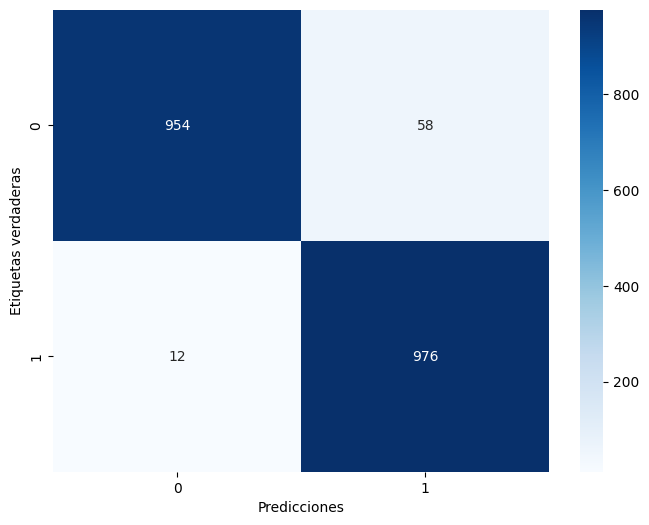

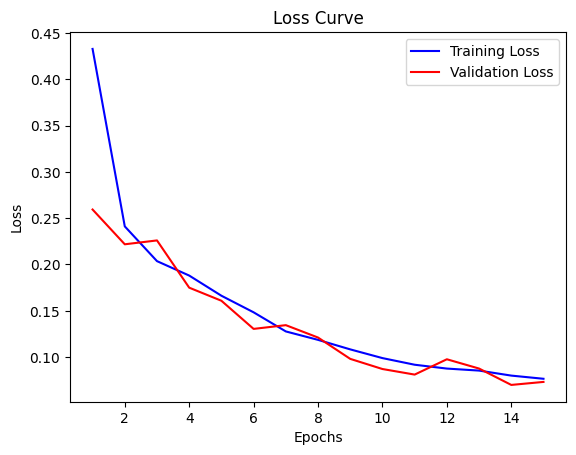

In [72]:
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.99      0.94      0.96      1012
 WithoutMask       0.94      0.99      0.97       988

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.96      2000
weighted avg       0.97      0.96      0.96      2000



# Entrenamiento con 30 épocas

In [75]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs = 30,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    verbose = 1
)

model.save("modelo_personalizado_30.h5")

Epoch 1/30
200/200 [==============================] - 3s 12ms/step - loss: 0.0740 - accuracy: 0.9750 - val_loss: 0.0794 - val_accuracy: 0.9781
Epoch 2/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0706 - accuracy: 0.9745 - val_loss: 0.0621 - val_accuracy: 0.9756
Epoch 3/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0716 - accuracy: 0.9720 - val_loss: 0.0753 - val_accuracy: 0.9744
Epoch 4/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0669 - accuracy: 0.9766 - val_loss: 0.0833 - val_accuracy: 0.9712
Epoch 5/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0652 - accuracy: 0.9759 - val_loss: 0.0716 - val_accuracy: 0.9750
Epoch 6/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0611 - accuracy: 0.9792 - val_loss: 0.0528 - val_accuracy: 0.9787
Epoch 7/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0602 - accuracy: 0.9784 - val_loss: 0.0692 - val_accuracy: 0.9762

# Métricas

In [76]:
# Evaluacion del rendimiento del modelo 
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9860
Test: accuracy = 0.986000  ;  loss = 0.045057 


63/63 [==============================] - 0s 4ms/step


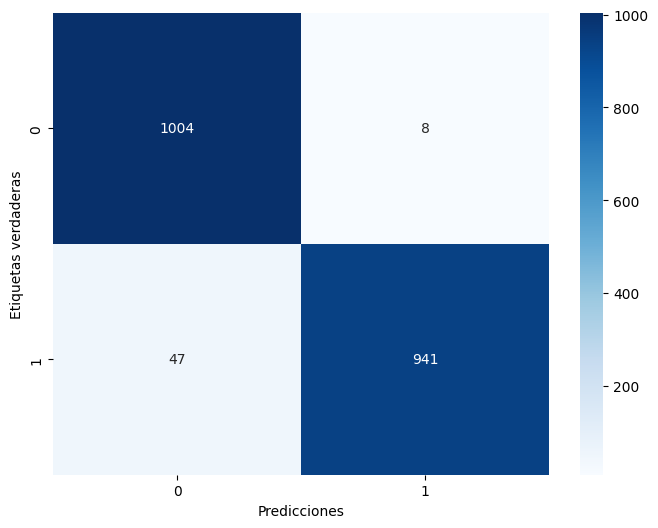

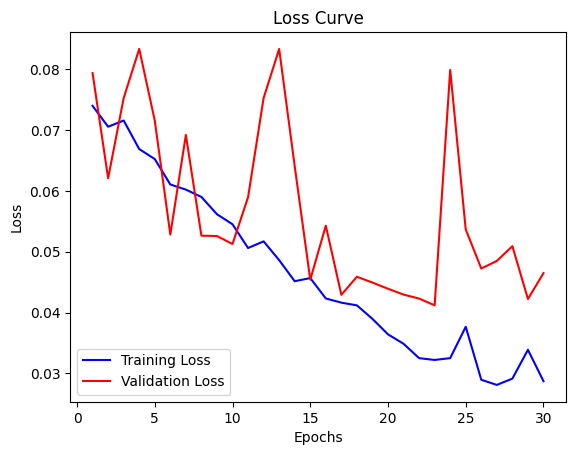

In [77]:
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.96      0.99      0.97      1012
 WithoutMask       0.99      0.95      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



# Entrenamiento con 60 épocas

In [80]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs = 60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    verbose = 1
)

model.save("modelo_personalizado_60.h5")

Epoch 1/60
200/200 [==============================] - 3s 12ms/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0474 - val_accuracy: 0.9794
Epoch 2/60
200/200 [==============================] - 2s 11ms/step - loss: 0.0255 - accuracy: 0.9909 - val_loss: 0.0435 - val_accuracy: 0.9844
Epoch 3/60
200/200 [==============================] - 2s 12ms/step - loss: 0.0261 - accuracy: 0.9905 - val_loss: 0.0466 - val_accuracy: 0.9844
Epoch 4/60
200/200 [==============================] - 2s 12ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 0.0505 - val_accuracy: 0.9844
Epoch 5/60
200/200 [==============================] - 2s 12ms/step - loss: 0.0222 - accuracy: 0.9914 - val_loss: 0.0495 - val_accuracy: 0.9856
Epoch 6/60
200/200 [==============================] - 2s 11ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0675 - val_accuracy: 0.9781
Epoch 7/60
200/200 [==============================] - 2s 12ms/step - loss: 0.0258 - accuracy: 0.9897 - val_loss: 0.0486 - val_accuracy: 0.9844

Epoch 58/60
200/200 [==============================] - 2s 12ms/step - loss: 8.8453e-04 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9850
Epoch 59/60
200/200 [==============================] - 2s 12ms/step - loss: 7.3141e-04 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9856
Epoch 60/60
200/200 [==============================] - 2s 12ms/step - loss: 8.0869e-04 - accuracy: 1.0000 - val_loss: 0.0682 - val_accuracy: 0.9831


# Métricas

In [81]:
# Evaluacion del rendimiento del modelo 
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 0s 6ms/step - loss: 0.0677 - accuracy: 0.9865
Test: accuracy = 0.986500  ;  loss = 0.067737 


63/63 [==============================] - 0s 4ms/step


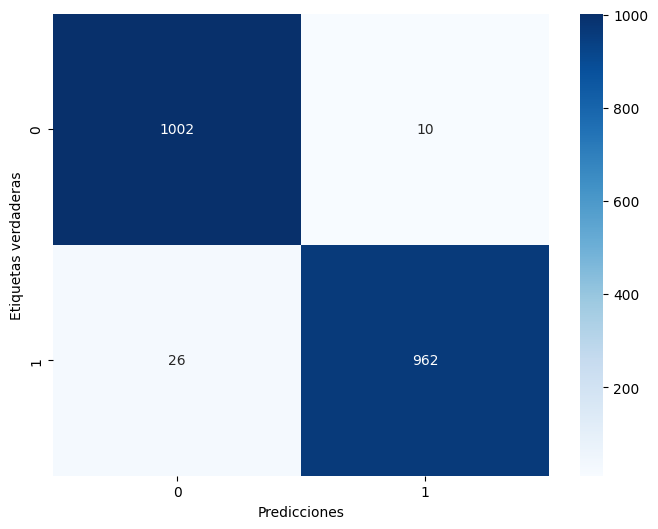

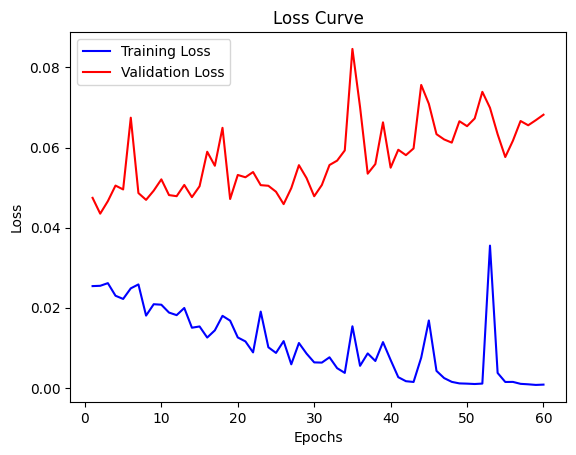

In [82]:
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.97      0.99      0.98      1012
 WithoutMask       0.99      0.97      0.98       988

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



# Pruebas

# 15 Épocas

In [97]:
model = load_model("modelo_personalizado_15.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 27ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithM

# 30 Épocas

In [96]:
model = load_model("modelo_personalizado_30.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 21ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithM

# 60 Épocas

In [95]:
model = load_model("modelo_personalizado_60.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 23ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithM